In [ ]:
from google.colab import drive
import os

# 將Google Drive掛載到Colab
drive.mount('/content/drive')

# 設定路徑
data_path = '/content/drive/My Drive/GAN/data'
save_path = '/content/drive/My Drive/GAN/save'

# 切換到資料集目錄
os.chdir(data_path)

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.file_list = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.file_list[idx])
        image = Image.open(img_path).convert('L')  # Open image as grayscale
        image = image.resize((64, 64))  # Resize image to 64x64
        if self.transform:
            image = self.transform(image)
        return image

# 建立資料集
dataset = CustomDataset(os.path.join(data_path), transform=ToTensor())

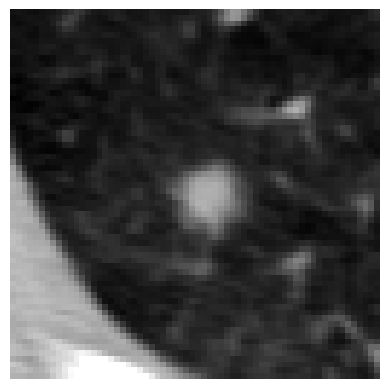

In [ ]:
import matplotlib.pyplot as plt

# 隨機獲取一張圖像
index = 0
sample_image = dataset[index]

# 顯示圖像
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# 生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 64*64),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 64, 64)
        return img

# 判別器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64*64, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(img.size(0), -1)
        validity = self.model(img)
        return validity

In [ ]:
# 初始化生成器和判別器
generator = Generator()
discriminator = Discriminator()

# 超參數設定
batch_size = 512
latent_dim = 1000
# 訓練迭代次數
num_epochs = 2000
# 定義優化器
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


# 定義損失函數
adversarial_loss = nn.BCELoss()
# 定義設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch.utils.data import DataLoader
import torchvision.utils as vutils

# 將生成器和判別器移動到設備上
generator = generator.to(device)
discriminator = discriminator.to(device)

# 設定資料載入器
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 訓練迴圈
for epoch in range(num_epochs):
    for i, real_images in enumerate(data_loader):
        # 將真實圖像移動到設備上
        real_images = real_images.to(device)

        # 創建目標標籤 (1 表示真實圖像)
        valid_labels = torch.ones((real_images.size(0), 1)).to(device)

        # 創建生成器的輸入噪點
        noise = torch.randn((real_images.size(0), latent_dim)).to(device)

        # 生成假圖像
        fake_images = generator(noise)

        # 計算生成器的損失
        generator_loss = adversarial_loss(discriminator(fake_images), valid_labels)

        # 更新生成器的參數
        optimizer_G.zero_grad()
        generator_loss.backward()
        optimizer_G.step()

        # 計算判別器的損失 (真實圖像的損失 + 假圖像的損失)
        real_loss = adversarial_loss(discriminator(real_images), valid_labels)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), torch.zeros_like(valid_labels))
        discriminator_loss = (real_loss + fake_loss) / 2

        # 更新判別器的參數
        optimizer_D.zero_grad()
        discriminator_loss.backward()
        optimizer_D.step()

    if (epoch % 100) == 0 or epoch == 1999:
      # 每個 epoch 結束後顯示損失
      print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {generator_loss.item():.4f}, Discriminator Loss: {discriminator_loss.item():.4f}")
      generator.eval()

      with torch.no_grad():
          # 生成一批樣本圖像
          sample_noise = torch.randn(25, latent_dim).to(device)
          sample_images = generator(sample_noise).cpu()

      # 顯示生成的圖像
      grid = vutils.make_grid(sample_images, nrow=5, normalize=True)
      plt.imshow(grid.permute(1, 2, 0))
      plt.axis('off')
      plt.show()
      generator.train()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 儲存生成器和判別器的參數到Google Drive
generator_path = os.path.join(save_path, 'generator.pth')
discriminator_path = os.path.join(save_path, 'discriminator.pth')
torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)

In [ ]:
# 建立測試資料集
test1_path = '/content/drive/My Drive/GAN/patches'
test1_dataset = CustomDataset(os.path.join(test1_path), transform=ToTensor())
test1_loader = DataLoader(test1_dataset, batch_size=batch_size, shuffle=False)

# 建立儲存生成圖像的目錄
test1_save_path = '/content/drive/My Drive/GAN/save/patches'
os.makedirs(test1_save_path, exist_ok=True)

In [ ]:
# 載入生成器的參數
generator = Generator()
generator.load_state_dict(torch.load(generator_path))
generator = generator.to(device)

# 生成一批圖像
generator.eval()
with torch.no_grad():
    for i, test_images in enumerate(test1_loader):
        # 將測試圖像移動到設備上
        test_images = test_images.to(device)

        # 創建噪點
        noise = torch.randn((test_images.size(0), latent_dim)).to(device)

        # 使用生成器生成圖像
        generated_images = generator(noise)

        # 保存生成的圖像
        for j, image in enumerate(generated_images):
            save_path = os.path.join(test1_save_path, f'image_{i * batch_size + j}.png')
            vutils.save_image(image.cpu(), save_path, normalize=True)

In [ ]:
# 建立測試資料集
test2_path = '/content/drive/My Drive/GAN/patch_Previous'
test2_dataset = CustomDataset(os.path.join(test2_path), transform=ToTensor())
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# 建立儲存生成圖像的目錄
test2_save_path = '/content/drive/My Drive/GAN/save/patch_Previous'
os.makedirs(test2_save_path, exist_ok=True)

In [ ]:
# 載入生成器的參數
generator = Generator()
generator.load_state_dict(torch.load(generator_path))
generator = generator.to(device)

# 生成一批圖像
generator.eval()
with torch.no_grad():
    for i, test_images in enumerate(test2_loader):
        # 將測試圖像移動到設備上
        test_images = test_images.to(device)

        # 創建噪點
        noise = torch.randn((test_images.size(0), latent_dim)).to(device)

        # 使用生成器生成圖像
        generated_images = generator(noise)

        # 保存生成的圖像
        for j, image in enumerate(generated_images):
            save_path = os.path.join(test2_save_path, f'image_{i * batch_size + j}.png')
            vutils.save_image(image.cpu(), save_path, normalize=True)

In [ ]:
# 建立測試資料集
test3_path = '/content/drive/My Drive/GAN/patch_Next'
test3_dataset = CustomDataset(os.path.join(test3_path), transform=ToTensor())
test3_loader = DataLoader(test3_dataset, batch_size=batch_size, shuffle=False)

# 建立儲存生成圖像的目錄
test3_save_path = '/content/drive/My Drive/GAN/save/patch_Next'
os.makedirs(test3_save_path, exist_ok=True)

In [ ]:
# 載入生成器的參數
generator = Generator()
generator.load_state_dict(torch.load(generator_path))
generator = generator.to(device)

# 生成一批圖像
generator.eval()
with torch.no_grad():
    for i, test_images in enumerate(test3_loader):
        # 將測試圖像移動到設備上
        test_images = test_images.to(device)

        # 創建噪點
        noise = torch.randn((test_images.size(0), latent_dim)).to(device)

        # 使用生成器生成圖像
        generated_images = generator(noise)

        # 保存生成的圖像
        for j, image in enumerate(generated_images):
            save_path = os.path.join(test3_save_path, f'image_{i * batch_size + j}.png')
            vutils.save_image(image.cpu(), save_path, normalize=True)